# Automatic Detection of Hyperparameters for k-NN Models

Alexis Rosenfeld & François Delafontaine

## 1. Objective of our project : meta-learning as training cost optimisation 

### What is **meta-learning**?

**Meta-learning**, often referred to as "learning to learn," is the process of improving the performance of machine learning systems by leveraging experiences from multiple tasks. It involves systematically observing how different algorithms perform across a variety of learning tasks and using this knowledge to adapt quickly to new tasks.

A key component of **meta-learning** is the use of **meta-features**, which are descriptive characteristics extracted from datasets. These features summarize properties such as:
- Dataset size
- Dimensionality (number of features)
- Statistical moments (e.g., mean, variance)
- Correlation or class imbalance

By analyzing the relationship between **meta-features** and the performance of algorithms, **meta-learning** systems can predict the best-performing hyperparameters or algorithms for a given dataset.

This enables **meta-learning** to:
1. Reduce computational costs by avoiding exhaustive search.
2. Generalize well to unseen tasks by learning from prior experiences.
3. Facilitate automated machine learning pipelines by intelligently selecting models or configurations.

<br>

> "Meta-learning, or learning to learn, is the science of systematically observing how different machine learning approaches perform on a wide range of learning tasks, and then learning from this experience, or meta-data, to learn new tasks much faster than otherwise possible."
>
> — *Hutter, F., Kotthoff, L., & Vanschoren, J. (2019). Automated Machine Learning: Methods, Systems, Challenges (p. 219). Springer Nature.*


### Our interest : knn training cost Optimisation

Meta-learning is allow us to avoid learning cost, in the case of KNN, we get from  $O(n^2)$ : 


``` python 
def k_evaluation(X,y):
    n_count = 0
    results = {}
    for k in range(X):
        predictions = []
        for x_test in X_test:  
            distances = [(np.sqrt(np.sum((x_train - x_test) ** 2)), label) for x_train, label in zip(X_train, y_train)]
            k_neighbors = [label for _, label in sorted(distances, key=lambda x: x[0])[:k]]
            predictions.append(max(set(k_neighbors), key=n_count))
        results[k] = accuracy_score(y_test, predictions)
        n_count += 1 
    return results


results = k_evaluation(X,y)
best_k = max(results, key=results.get)
``` 

into a single $O(1)$ using regression 

``` python 
y = beta0 + beta1 + X[0] + beta2 X[1] ... 

```

as long as we get a good model

## 2. Data & features


### State of the art in scientific research
Scientist did research about meta-features 
<figure>
  <img src="fig/img_meta.png" width="80%"/>
  <figcaption>
    <strong>Part of meta-features table from our ref. Book</strong><br>
    <em>— Hutter, F., Kotthoff, L., & Vanschoren, J. (2019). Automated Machine Learning: Methods, Systems, Challenges (p. 219). Springer Nature.</em>
  </figcaption>
</figure>
<br>

### Data sources 

We recognize, for this project, three types of data:
1. Real: datasets found online
2. Simulated: datasets where `k` is generated first, then `mx` derived through formulas.
3. Tested: datasets where `mx` is generated first and `k` obtained through k-NN iteration.


### Our **meta-features**

This presentation will rely solely on (3), as the data generated can also be used to train, test and evaluate our model. We plan to use (2) to test model's behavior and eventually (1) as a more general evaluation.

As for the features, we followed the following leads:
- A rule of thumb where `k` = $$ \frac{\sqrt{\text{number of datapoints}}}{2} $$

- The level of noise, which here will mean how much the datapoints overlap.
- Potentially the type of distribution (linear, quadratic, etc.).

We therefore selected the following `mx` features:
* a) n_rows: the number of `A`'s datapoints
* b) n_classes: with `A` having a categorical dependent variable, this is its number of values
* c) n_features: the number of `A`'s features
* d) n_nonrand: the number of `A`'s features that are non-random (defined by correlation, weighted by (c))
* e) distr_type: the type of distribution the non-random features follow (linear, quadratic, partial)
* f) distr_noise: how likely the values are to overlap (how wide the interval for data generation)
* g) mean_var: the average sum of variance of `A`'s features, weighted by (a\*c)
* h) mean_skew: the average sum of skew of `A`'s features, weighted by (a\*c)
* i) mean_kurtosis: the average sum of kurtosis of `A`'s features, weighted by (a\*c)

And generated a ~4,000 datapoints `D` dataset. The code below illustrates what an `A` dataset looks like, as well as the relations between `best_k` and each of our 9 features.

In [1]:
from kguesser import KG_test
kg_test = KG_test()
# dat = kg_test.sim(10000, "kg_test.xlsx", verbose=True)
dat = kg_test.load("kg_test.xlsx") # load dataset

In [2]:
kg_test.show(dat)

   best_k  n_rows  n_classes  n_features  n_nonrand  distr_type  distr_noise  \
0    25.0  4202.0        5.0         9.0   0.444444        1.75          2.0   
1    19.0  1520.0        5.0         4.0   0.250000        1.00          2.0   
2    38.0  2171.0        3.0         3.0   0.333333        2.00          2.0   
3     1.0   186.0        4.0         5.0   0.400000        2.50          3.0   
4     3.0  4546.0        4.0         8.0   0.500000        2.50          1.0   

     mean_var  mean_skew  mean_kurtosis  
0   18.419677   0.000011      -0.000259  
1   52.765363  -0.000006      -0.000757  
2   33.434211   0.000049      -0.000530  
3  422.738103   0.000719      -0.005518  
4   15.357451  -0.000003      -0.000261  


/Users/alexisrosenfeld/Desktop/ML_with_VnrDrFrancois/Delafontaine_Rosenfeld_Presentation/kguesser.py:254: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


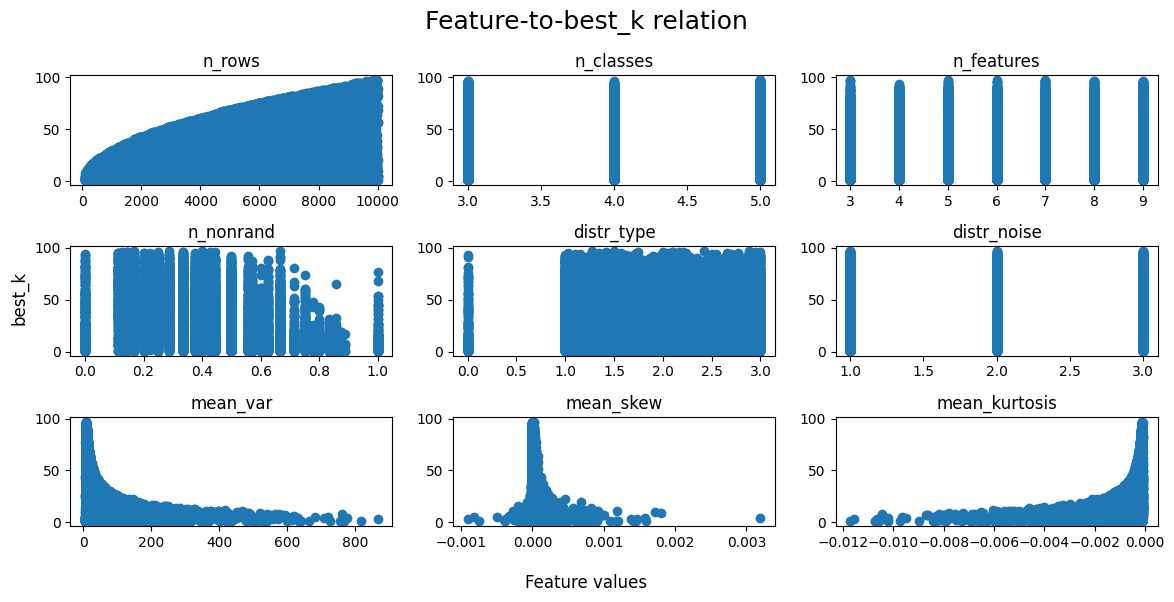

In [3]:
kg_test.show_features(dat) # show feature relations with 'best_k'

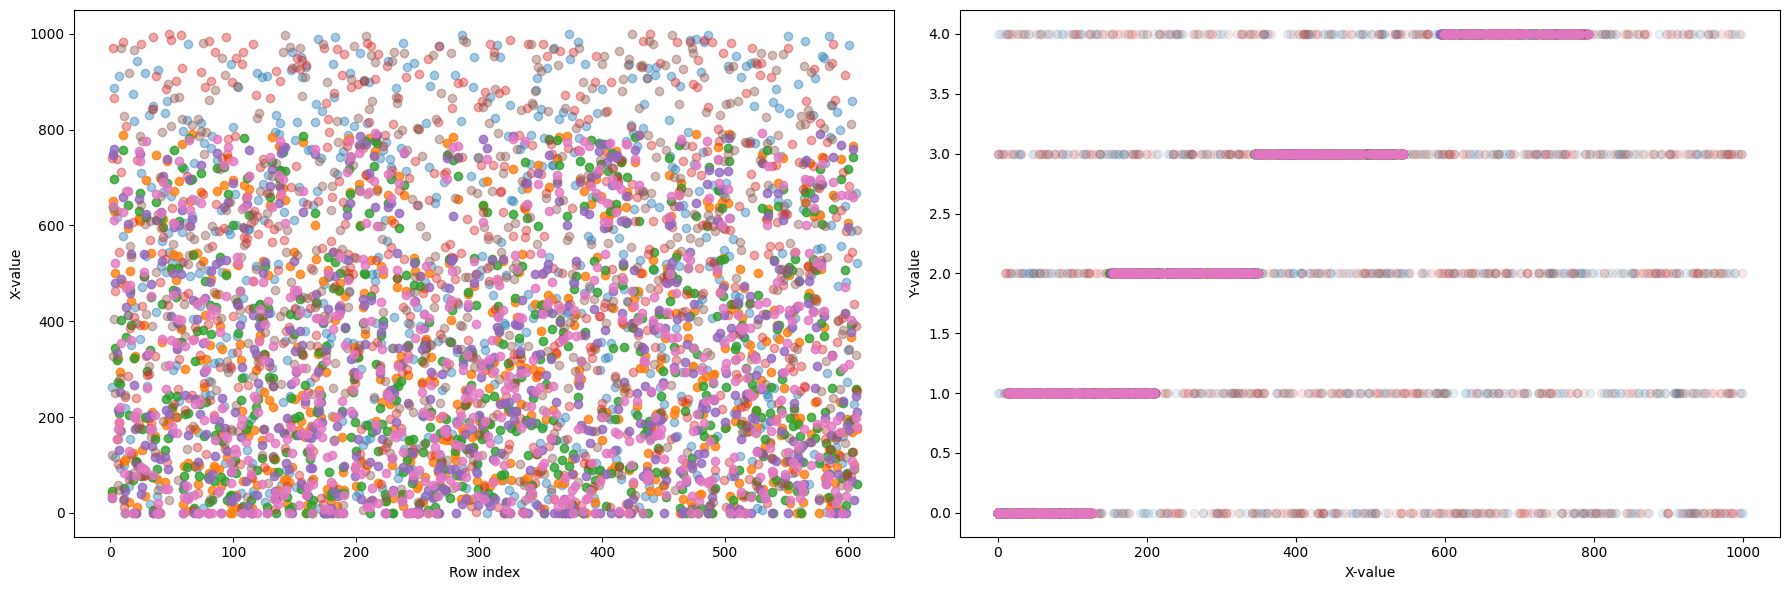

   y   x1   x2   x3   x4   x5   x6   x7
0  1  263   39   45  740   31  121   32
1  4  750  652  638  971  748  327  641
2  4  888  630  697  867  760  405  612
3  3  117  500  345  463  479  250  522
4  2  617  154  319  739  334  631  155


In [4]:
kg_test.params({'lim_row':[500,1000], 
                'distr_type':2, 
                'distr_noise':1})        # control generation (limited)
x, y, d_vi = kg_test.generate(view=True) # generate&plot a dataset
kg_test.show(x, y, columns=["y"]+[f"x{i+1}" for i in range(x.shape[1])])

In [5]:
vf = [f"{kg_test.head[i+1]}: {v}" for i, v 
      in enumerate(kg_test.get_features(x, y, d_vi))] # generation values
for txt in vf:
    print(txt)

n_rows: 607
n_classes: 5
n_features: 7
n_nonrand: 0.5714285714285714
distr_type: 1.6882968877392355
distr_noise: 1
mean_var: 109.68671357209399
mean_skew: 0.00044492685332991856
mean_kurtosis: -0.0017205186051312325


## 3. Pipeline

### Pre-process

Once the dataset has been obtained, we preprocess it in three steps:
1. One-hot encoding: We split categorical columns into multiple binary ones
2. Scaling: Values vary from e4 to e-4 or more. We scale them around e0 (and restore categoricals to 0/1 values)
3. Feature selection: We remove features that don't get at least a 0.2 correlation (categorical columns of a given feature are all kept)

A manual feature selection could also be done, if only by iterating models, so our pipeline allows for skipping step (3).

In [6]:
from kguesser import KG_model

kg_model = KG_model()
x, y = kg_model.preprocess(dat[:,1:], dat[:,0], verbose=False)
kg_model.show(x, y)

   best_k    n_rows  n_nonrand  distr_noise_1  distr_noise_2  distr_noise_3  \
0    25.0 -0.303060   0.208002            0.0            1.0            0.0   
1    19.0 -1.242738  -0.768364            0.0            1.0            0.0   
2    38.0 -1.014651  -0.349921            0.0            1.0            0.0   
3     1.0 -1.710125  -0.015168            0.0            0.0            1.0   
4     3.0 -0.182534   0.486963            1.0            0.0            0.0   

   mean_var  mean_kurtosis  
0 -0.249819       0.265517  
1  0.273149      -0.254489  
2 -0.021198      -0.017137  
3  5.906579      -5.224432  
4 -0.296446       0.262885  


### Model

Since the `k` is a quantitative value, we chose to train a Linear Regression model. We test that model in two ways:
1. A 5-fold cross-validation on a training subset
2. An MSE/R2 score on the entire set

This means we split our dataset into a training and an evaluation dataset, use the training set for the cross-validation then train our model on that entire training set and get our MSE and R2 scores using the evaluation set. 

It is technically possible to retrieve more information on the linear regression model (coefficient, std, t-value, p-value). This is only partially implemented. [Note: As in I sometimes can't inverse the matrix, othertimes get divisions by zero and basically it's not worth the effort.]

In [7]:
kg_model.test_lm(x, y, preprocess=False); print("")

#---------------------------------------- 
|Model Performance:
|Cross-validation mean: 0.37 , std: 0.03
|Mean Square Error: 392.17
|R² Score: 0.36#----------------------------------------




Since the linear regression model is offering mitigated results, we can test another model. We will test a neuronal network. 

In [9]:
kg_model.test_nn(x, y, params={'hidden_layer_sizes':[x.shape[1], 64, 32, 32]}, 
                 preprocess=False); print("")

/Users/alexisrosenfeld/.local/share/virtualenvs/alexisrosenfeld-3CWC9XQS/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/alexisrosenfeld/.local/share/virtualenvs/alexisrosenfeld-3CWC9XQS/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/alexisrosenfeld/.local/share/virtualenvs/alexisrose

#---------------------------------------- 
|Model Performance:
|Cross-validation mean: 0.49 , std: 0.03
|Mean Square Error: 296.66
|R² Score: 0.50#----------------------------------------




/Users/alexisrosenfeld/.local/share/virtualenvs/alexisrosenfeld-3CWC9XQS/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## 4. Results

### Evaluation of the model

So far, our results suggest that the linear regression model is adapted to the task: a more powerful model doesn't seem to get better results. Likewise, while our features are limited (and noisy), `n_rows` and `mean_var` in particular seem significant enough. 

Therefore our efforts would focus on the simulations. For the purpose of testing the model, our generation is too complex. By generating more predictable data (and especially by isolating each feature) we should get a better idea of the model's behavior and, eventually, how to raise its accuracy.

### Evaluating meta-learning processes

To evaluate a **meta-learning process**, we propose assessing the **accuracy** of raw datasets using the optimal hyperparameter \( k \) in \( k \)-nearest neighbors (KNN) models. Specifically, we define:

1. **Optimal \( k \):** For a given dataset, the value of \( k \) that maximizes the accuracy of the KNN model.
2. **Estimated \( $\hat{k}$ \):** The value of \( k \) predicted by the meta-learning process for the same dataset.

We then compute a **delta accuracy metric**:

$$
\Delta \text{Accuracy} = \text{Mean Accuracy of optimal } k - \text{Mean Accuracy of estimated } \hat{k}
$$

Where:
- **Mean Accuracy of optimal \( k \):** The average accuracy achieved by the best \( k \) across multiple datasets.
- **Mean Accuracy of estimated \( $\hat{k}$ \):** The average accuracy achieved by the \( $\hat{k}$ \) values predicted by the meta-learning process.

This metric quantifies the performance gap between the optimal and meta-predicted hyperparameters, offering a robust evaluation of the meta-learning process.